In [110]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

from tqdm.notebook import tqdm
from collections import namedtuple
from collections import deque
import random

## TicTacToe Game environment

We start with a 3x3 tic tac toe (ttt) game for two players. The players take turns placing their respective symbol X or O into the grid until one gets a vertical, horizontal or diagonal line of three to win or all spaces get filled and the game ends in a draw.

## Termination conditions

The game terminates when a player wins or when a draw is reached. There is no truncation, each game lasts at most 9 moves while on a 3x3 grid.

## Rewards

The agent recieves a +0 reward after each round (each turn by each player), unless they have: 
won -> reward +2, end, 
lost -> reward -2, end, or 
drawn the game -> reward +1

## Observations
At each time point (turn), the RL agent receives the list of already present symbols on the grid in a 2D list format.

## Action space
The agent chooses a set of empty coordinates on the grid to place its symbol.


In [111]:
class TictacEnv:
    """
    The class representing the game environment.
    """
    def __init__(self, size=3, randomOpponent=False, opponentSymbol = -1, visualise = False, randomStart = False, maxRounds = 20):
        self.size = size
        self.randomStart = randomStart
        self.opponentSymbol = opponentSymbol
        self.maxRounds = maxRounds
        self.board = np.zeros((size,size), np.int8)
        if randomStart and (np.random.random() > 0.5):
            self.board[np.random.randint(size), np.random.randint(size)] = opponentSymbol
        self.actionSpaceSize = size**2
        self.observationSpaceSize = size**2
        self.randomOpponent = randomOpponent
        if randomOpponent:
            self.rewardValues = {'undecided': 0, 'win_1': 50, 'win_-1': -5, 'illegal': -10, 'draw': 0}
        else:
            self.rewardValues = {'undecided': 0, 'win_1': 50, 'win_-1': 5, 'illegal': -10, 'draw': 0}
        self.visualise = visualise
        self.round = 0

    def _getObs(self):
        return self.board.flatten()

    def _updateBoard(self, row, column, symbol):
        if self.board[row, column] != 0:
            raise ValueError("Playing in an occupied field.")
        if (symbol != 1) and (symbol != -1):
            raise ValueError("Symbol to play not valid - must be 1 or -1.")
        self.board[row, column] = symbol

    def _legalMove(self, row, column):
        return self.board[row, column] == 0

    def _eval(self):
        rows = np.array(np.vsplit(np.transpose(self.board), self.size))[:,0,:]
        columns = np.array(np.vsplit(self.board, self.size))[:,0,:]
        diagonals = np.array([[self.board[i,i] for i in range(self.size)], [self.board[i,self.size - i - 1] for i in range(self.size)]])
        lines = np.vstack([rows,columns,diagonals])
        for line in lines:
            if np.all(line == line[0]) and line[0] != 0:
                if line[0] == 1:
                    return 'win_1'
                else:
                    return 'win_-1'
        if not np.any(self.board == 0):
            return 'draw'
        return 'undecided'

    def _terminated(self, eval):
        return eval == 'win_1' or eval == 'win_-1' or eval == 'draw'

    def step(self, action):
        if action.field >= self.size**2 or action.field < 0:
            raise IndexError("Updating a nonexistent field.")
        row = action.field // self.size
        column = action.field % self.size

        eval = 'illegal'
        if self._legalMove(row, column):
            self._updateBoard(row, column, action.symbol)
            eval = self._eval()

        if self.randomOpponent and eval == 'undecided':
            randomRow, randomColumn = self.randomPlay()
            self._updateBoard(randomRow, randomColumn, self.opponentSymbol)
            eval = self._eval()
        
        reward = self.rewardValues[eval]
        observation = self._getObs()
        terminated = self._terminated(eval)
        truncated = self.round >= self.maxRounds
        info = None
        #self.state = self.board.flatten()
        if self.visualise:
            self.printBoard()
            print(observation, reward, terminated, truncated, info)
        
        self.round += 1
        return observation, reward, terminated, truncated, info

    # def _getReward(self, eval):
    #     if eval == 'undecided':
    #         reward = len(np.where(self.board > 0))
    #     else:
    #         reward = self.rewardValues[eval]
    #     return reward

    def randomPlay(self):
        emptyFields = np.where(self.board == 0)
        emptyCoords = list(zip(emptyFields[0], emptyFields[1]))
        randomField = emptyCoords[np.random.choice(len(emptyCoords))]
        return randomField[0], randomField[1]

    def reset(self):
        self.board = np.zeros((self.size,self.size), np.int8)
        if self.randomStart and (np.random.random() > 0.5):
            self.board[np.random.randint(self.size), np.random.randint(self.size)] = self.opponentSymbol
        self.round = 0
        observation = self._getObs()
        return observation
    
    def printBoard(self):
        print("\n---------\n".join([" | ".join(row) for row in self.board.astype(str)]) + "\n")

class Action:
    def __init__(self, field, symbol):
        self.field = field
        if (symbol != 1) and (symbol != -1):
            raise ValueError("Symbol to play not valid - must be 1 or -1.")
        self.symbol = symbol

In [112]:
# testEnv = TictacEnv(size=3, randomOpponent=True, visualise=True, randomStart=True)

# action = Action(field = 5, symbol = 1)
# testEnv.step(action)

# action = Action(field = 5, symbol = 1)
# testEnv.step(action)

# action = Action(field = 5, symbol = 1)
# testEnv.step(action)

# action = Action(field = 5, symbol = 1)
# testEnv.step(action)



# DQN algorithm components

The DQN algorithm requires the following components, with the following roles:
1. **Value network**: A neural network that takes in states and outputs predictions for the value of each action in that state
2. **Target network**: A copy of the value network with lagged parameters that is used to compute the target values for the regression targets
3. **Replay buffer**: A buffer that stores transitions (state, action, reward, next_state, terminated) that the agent has experienced. This is used to sample mini-batches of transitions to train the value network
4. **Policies**: These use the value network to select actions in the environment. We will consider two policies:
    - **Greedy policy**: This policy selects the action with the highest value, and is used to evaluate the value network
    - **$\epsilon$-greedy policy**: This policy selects a random action with probability $\epsilon$, and the action with the highest value with probability 1-$\epsilon$. This is used to explore the environment using the training phase. 
   

## The value and target networks

We start by defining the value network architecture. This is a simple feedforward neural network (a **multi-layer perceptron**). 
The input to the network is the state of the environment, and the output is the value prediction of each action.

In [113]:
# Define the Q_net class
class Q_net(nn.Module):
    # Initialise the network using the size of the observation space and the number of actions
    def __init__(self, obs_size, n_actions):
        # Use the nn.Module's __init__ method to ensure that the parameters can be updated during training
        super().__init__()

        # Define the layers of the network
        self.Network = nn.Sequential(
            nn.Linear(obs_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
            nn.Softplus()
        )


    # Define the forward method
    def forward(self, x):
        return self.Network(x)

## The replay buffer

To implement the replay buffer, we first define a named tuple data type to store transitions. We then define the replay buffer class, which stores transitions and can sample mini-batches of transitions. The replay buffer has the following methods:
1. **Push**: This method stores a new transition in the buffer, and removes the oldest transition if the buffer is full
2. **Sample**: This method samples a mini-batch of transitions from the buffer

In [114]:
# Define the transition named tuple
# This will be used to store the transitions (state, action, reward, next_state, terminated) in the replay buffer
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'terminated'))

# Define the ReplayBuffer class
class ReplayBuffer:
    # Initialise the buffer with a capacity. 
    def __init__(self, capacity):
        # Use a deque object to implement the buffer
        self.buffer = deque(maxlen=capacity)

    # Define the push method to add a transition to the buffer
    def push(self, state, action, reward, next_state, terminated):
        self.buffer.append(Transition(state, action.field, reward, next_state, terminated))

    # Sample a batch of transitions for training
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

## The DQN agent
We now define the DQN agent class. This class will have:
1. **A value network**, implemented using the Q_net class
2. **A target network**, implemented using the Q_net class
3. **A replay buffer**, implemented using the ReplayBuffer class
4. **An optimiser**, which is used to train the value network

The DQN agent will have the following methods:
1. **Greedy policy**: This method selects the action with the highest value
2. **$\epsilon$-greedy policy**: This method selects a random action with probability $\epsilon$, and the action with the highest value with probability 1-$\epsilon$
3. **Sync**: This method synchronises the target network with the value network by loading the parameters of the value network into the target network

In [115]:
# Define the DQN_agent class
class DQN_agent:
    def __init__(self, obs_size, n_actions, symbol, buffer_capacity=200000, gamma=0.95, epsilon=0.05, lr=0.005, batch_size=32):
        # Save the hyperparameters (buffer_capacity, gamma, epsilon, lr, batch_size)
        self.buffer_capacity = buffer_capacity
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.batch_size = batch_size
        self.symbol = symbol
        
        # Save the number of actions and the observation size
        self.n_actions = n_actions
        self.obs_size = obs_size

        # Define the value network for the agent. 
        self.value_network = Q_net(obs_size, n_actions)
        # Define the target network for the agent.
        self.target_network = Q_net(obs_size, n_actions)
        # Sync the networks
        self.sync()
        # Define the replay buffer
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        # Define the optimizer
        self.optimiser = optim.Adam(self.value_network.parameters(), lr=lr)


    # Define the sync method to sync the target network with the value network
    def sync(self):
        self.target_network.load_state_dict(self.value_network.state_dict())


    # Define the greedy policy
    def greedy_policy(self, state):
        # Enter no-gradient mode (since we are not training the network when we sample actions)
        with torch.no_grad():
            # Convert the state to a tensor
            state = torch.tensor(state, dtype=torch.float32)
            # Compute the Q values for the state using the value network
            q_values = self.value_network(state)
            # Find the action with the highest Q value, converting it to a integer
            max_action = q_values.argmax().item()
            # Return the action
            return Action(max_action, self.symbol)
            

    # Define the epsilon greedy policy 
    def epsilon_greedy_policy(self, state):
        # Sample a random number uniformly betwen 0 and 1  
        rand_num = np.random.random()

        # If the random number is less than the exploration rate, choose a random action
        if rand_num < self.epsilon:
            # Choose a random action
            action = np.random.randint(0, self.n_actions)
            # Return the action
            return Action(action, self.symbol)
        
        # Otherwise, choose the action with the highest Q value
        else:
            # Return the greedy policy to choose the action
            return self.greedy_policy(state)

## Interacting with the environment
During training, the DQN agent must interact with the environment in order to collect transitions to be added to the replay buffer. We define an **interact** function that takes in the environment, the DQN agent, and the number of time steps to interact for. This function will use the $\epsilon$-greedy policy to select actions, and will store the transitions in the replay buffer. 

In [116]:
# Define the interact method
# This method takes in an agent, an environment, and the number of steps to interact for.
def interact(agent, env, n_steps):
    # Loop over the steps
    for step in range(n_steps):
        # Get the current state
        state = env._getObs()
        # Choose an action using the epsilon greedy policy
        action = agent.epsilon_greedy_policy(state)
        # Take a step in the environment using the action
        next_state, reward, terminated, truncated, info = env.step(action)
        # Push the transition to the replay buffer
        agent.replay_buffer.push(state, action, reward, next_state, terminated)
        # Reset the environment if the episode is terminated or truncated
        if terminated or truncated:
            env.reset()

            

def interact_for_two(agent1, agent2, env, n_steps):
    # Loop over the steps
    for step in range(n_steps):
        # Get the current state
        state = env._getObs()
        # Choose an action using the epsilon greedy policy
        action = agent1.epsilon_greedy_policy(state)
        # Take a step in the environment using the action
        next_state, reward, terminated, truncated, info = env.step(action)
        # Push the transition to the replay buffer
        agent1.replay_buffer.push(state, action, reward, next_state, terminated)
        # Reset the environment if the episode is terminated or truncated
        if terminated or truncated:
            env.reset()
        
        # Get the current state
        state = env._getObs()
        # Choose an action using the epsilon greedy policy
        action = agent2.epsilon_greedy_policy(state * (-1))
        # Take a step in the environment using the action
        next_state, reward, terminated, truncated, info = env.step(action)
        # Push the transition to the replay buffer
        agent2.replay_buffer.push(state * (-1), action, reward, next_state * (-1), terminated)
        # Reset the environment if the episode is terminated or truncated
        if terminated or truncated:
            env.reset()

## Training the DQN agent

We define a **update weights** function that updates the weights of the value network for a DQN agent. This function will:
1. Sample a mini-batch of transitions from the replay buffer
2. Extracts the states, actions, rewards, next_states, and terminated flags from the transitions
3. Uses the target network, rewards, and terminated flags to compute the target values for the value network 
4. Computes the loss between the value network predictions and the target values
5. Runs backpropagation and updates the weights of the value network using that loss

As a reminder, the regression targets for $Q(S,A)$ are given by:
$$ R + \gamma (1-\text{terminated}) \max_{A'} Q(S',A')$$

In [117]:
# This method updates the weights of the value-network of the agent using a batch of transitions
def update_weights(agent):
    # Sample a batch of transitions from the replay buffer
    batch = agent.replay_buffer.sample(agent.batch_size)
    
    # Extract the batch of states as float32 tensors 
    states = torch.tensor(np.array([transition.state for transition in batch]), dtype=torch.float32)
    # Extract the batch of actions as int64 tensors
    actions = torch.tensor(np.array([transition.action for transition in batch]), dtype=torch.int64)
    # Extract the batch of rewards as float32 tensors
    rewards = torch.tensor(np.array([transition.reward for transition in batch]), dtype=torch.float32)
    # Extract the batch of next states as float32 tensors
    next_states = torch.tensor(np.array([transition.next_state for transition in batch]), dtype=torch.float32)
    # Extract the batch of terminated flags as bool tensors
    terminated = torch.tensor(np.array([transition.terminated for transition in batch]), dtype=torch.bool)

    # Compute the next state values using the target network
    next_state_values = agent.target_network(next_states)
    # Take the max over the actions (dim=1) 
    max_next_values = next_state_values.max(dim=1)[0] 
    # Zero out the max-next-values for the terminal states
    max_next_values[terminated] = 0
    # Compute the target values
    target_values = rewards + agent.gamma * max_next_values

    # Compute the Q values for all actions
    q_values = agent.value_network(states)
    # Compute the Q values for the actions that were taken
    q_SA = q_values[torch.arange(q_values.size(0)), actions]
    # Compute the loss using the mean squared error
    loss = F.mse_loss(q_SA, target_values)
    
    # Zero the gradients using the optimiser
    agent.optimiser.zero_grad()
    # Compute the gradients of the loss through backpropagation
    loss.backward()
    # Update the weights of the value network using the gradients
    agent.optimiser.step()
    
    # return the loss (as a float)
    return loss.item()


## The training loop for the agent
We now put everything together into a training loop for the DQN agent. This loop will:
1. Interact with the environment for a number of time steps
2. Update the weights of the value network
3. Synchronize the target network with the value network at regular intervals

In [118]:
# Define the train_loop method
def train_loop(agent, env, interactions_per_update, update_steps, sync_delay):
    # Initialise the environment
    env.reset()

    # Initialise the list of losses
    losses = []

    # Gather initial interactions for the experience replay buffer
    interact(agent, env, 1000)
    
    # Loop over the update_steps
    for step in tqdm(range(update_steps)):
        # Interact with the environment
        interact(agent, env, interactions_per_update)
        
        # Update the weights
        losses.append(update_weights(agent))

        # Sync the networks every sync_delay steps
        if step % sync_delay == 0:
            agent.sync()
    
    # Return the losses
    return losses

def train_loop_for_two(agent1, agent2, env, interactions_per_update, update_steps, sync_delay):
    # Initialise the environment
    env.reset()

    # Initialise the list of losses
    losses1 = []
    losses2 = []

    # Gather initial interactions for the experience replay buffer
    interact_for_two(agent1, agent2, env, 1000)
    
    # Loop over the update_steps
    for step in tqdm(range(update_steps)):
        # Interact with the environment
        interact_for_two(agent1, agent2, env, interactions_per_update)
        
        # Update the weights
        losses1.append(update_weights(agent1))
        # Update the weights
        losses2.append(update_weights(agent2))

        # Sync the networks every sync_delay steps
        if step % sync_delay == 0:
            agent1.sync()
            agent2.sync()
    
    # Return the losses
    return losses1, losses2
    

## Some helper functions
We define some helper functions to:
1. Evaluate the agent's performance
2. Visualise the agent's performance
3. Plot the (smoothed) losses during training

In [119]:
# Define the evaluate function
def evaluate(agent, env, n_episodes):
    # Initialise the list of rewards
    rewards = []
    
    # Loop over the episodes
    for episode in tqdm(range(n_episodes)):
        print("Game " + str(episode) + "\n")
        # Reset the environment
        env.reset()
        # Get the initial state
        state = env._getObs()
        # Initialise the episode reward
        episode_reward = 0
        
        # Loop over the steps
        while True:
            # Choose the action with the highest Q value
            action = agent.greedy_policy(state)
            # Take the action
            next_state, reward, terminated, truncated, info = env.step(action)

            # Update the state and reward
            state = next_state
            episode_reward += reward
            # Break if the episode has terminated
            if terminated or truncated:
                break
        
        # Append the episode reward to the list of rewards
        rewards.append(episode_reward)
    # Return the mean of the rewards
    return np.mean(rewards)

In [120]:
# Define the visualise function
# This displays the agent's behaviour in the environment for 500 steps.  
def visualise(agent, env, n_steps):
    # Reset the environment
    env.reset()

    # Initialise the list of frames   
    frames = []

    for _ in range(n_steps):
        # Render the environment and store the frame
        frames.append(env.render())

        # Take an action using the greedy policy
        state = env._getObs()
        action = agent.greedy_policy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            env.reset()

    # Display the movie
    for frame in frames:
        clear_output(wait=True)
        plt.imshow(frame)
        plt.show()
        sleep(0.003)

In [121]:
# Plot a smoothed version of the losses for the regression training
def plot_losses(losses):
    # Create a smoothed version of the losses
    smoothed_losses = np.convolve(losses, np.ones(1000)/1000, mode='valid') 
    plt.plot(smoothed_losses)
    plt.xlabel('Update step')
    plt.ylabel('Loss')
    plt.xlim(0, len(smoothed_losses))
    plt.ylim(0, 1.1*max(smoothed_losses))
    plt.show()

# Let's gooooo

We will now train our network using the DQN algorithm and visualise the agent's performance. Have fun!

In [122]:
# Create the environment
env = TictacEnv(size=4, randomOpponent=True, visualise=False, randomStart=True)
# Testing env
testEnv = TictacEnv(size=4, randomOpponent=True, visualise=True, randomStart=True)

# Reset the environment
env.reset()
# Create the agent
agent1 = DQN_agent(env.observationSpaceSize, env.actionSpaceSize, symbol= 1, epsilon=0.2)
#agent1.value_network.load_state_dict(torch.load("trained_value_network.pth"))
#agent1.target_network.load_state_dict(torch.load("trained_value_network.pth"))

In [123]:
# Evaluate the agent's performance before training
print('Performance before training:', evaluate(agent1, testEnv, 50))

  0%|          | 0/50 [00:00<?, ?it/s]

Game 0

-1 | 0 | 0 | 0
---------
0 | 0 | 0 | 0
---------
0 | 1 | 0 | 0
---------
0 | 0 | 0 | 0

[-1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0] 0 False False None
-1 | 0 | 0 | 0
---------
0 | 0 | 0 | 0
---------
0 | 1 | 0 | 0
---------
0 | 0 | 0 | 0

[-1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0] -10 False False None
-1 | 0 | 0 | 0
---------
0 | 0 | 0 | 0
---------
0 | 1 | 0 | 0
---------
0 | 0 | 0 | 0

[-1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0] -10 False False None
-1 | 0 | 0 | 0
---------
0 | 0 | 0 | 0
---------
0 | 1 | 0 | 0
---------
0 | 0 | 0 | 0

[-1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0] -10 False False None
-1 | 0 | 0 | 0
---------
0 | 0 | 0 | 0
---------
0 | 1 | 0 | 0
---------
0 | 0 | 0 | 0

[-1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0] -10 False False None
-1 | 0 | 0 | 0
---------
0 | 0 | 0 | 0
---------
0 | 1 | 0 | 0
---------
0 | 0 | 0 | 0

[-1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0] -10 False False None
-1 | 0 | 0 | 0
---------
0 | 0 | 0 | 0
-

In [124]:
# Visualise the agent's behaviour before training
#visualise(agent, env, 100)

In [126]:
# Train the agent, saving the losses
losses = train_loop(agent1, env, interactions_per_update=10, update_steps=20000, sync_delay=1000)

  0%|          | 0/20000 [00:00<?, ?it/s]

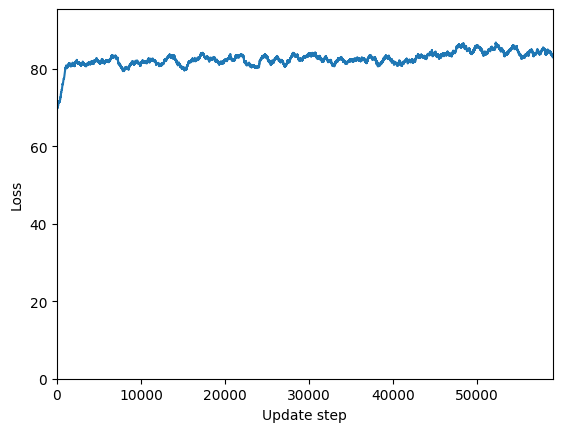

In [109]:
# Plot the losses
plot_losses(losses)

In [45]:
# Evaluate the agent's performance after training
print('Performance after training:', evaluate(agent1, testEnv, 300))

  0%|          | 0/300 [00:00<?, ?it/s]

Game 0

0 | -1 | 0
---------
0 | -1 | 0
---------
1 | 0 | 0

[ 0 -1  0  0 -1  0  1  0  0] 0 False False None
0 | -1 | -1
---------
0 | -1 | 0
---------
1 | 1 | 0

[ 0 -1 -1  0 -1  0  1  1  0] 0 False False None
0 | -1 | -1
---------
0 | -1 | 0
---------
1 | 1 | 1

[ 0 -1 -1  0 -1  0  1  1  1] 50 True False None
Game 1

0 | 0 | -1
---------
0 | 0 | 0
---------
1 | 0 | 0

[ 0  0 -1  0  0  0  1  0  0] 0 False False None
0 | 0 | -1
---------
0 | 0 | -1
---------
1 | 0 | 1

[ 0  0 -1  0  0 -1  1  0  1] 0 False False None
1 | 0 | -1
---------
0 | -1 | -1
---------
1 | 0 | 1

[ 1  0 -1  0 -1 -1  1  0  1] 0 False False None
1 | 0 | -1
---------
0 | -1 | -1
---------
1 | 1 | 1

[ 1  0 -1  0 -1 -1  1  1  1] 50 True False None
Game 2

0 | 0 | -1
---------
0 | 0 | -1
---------
1 | 0 | 0

[ 0  0 -1  0  0 -1  1  0  0] 0 False False None
0 | 0 | -1
---------
-1 | 0 | -1
---------
1 | 0 | 1

[ 0  0 -1 -1  0 -1  1  0  1] 0 False False None
0 | 0 | -1
---------
-1 | 0 | -1
---------
1 | 1 | 1

[ 0  0 -1

  0%|          | 0/100000 [00:00<?, ?it/s]

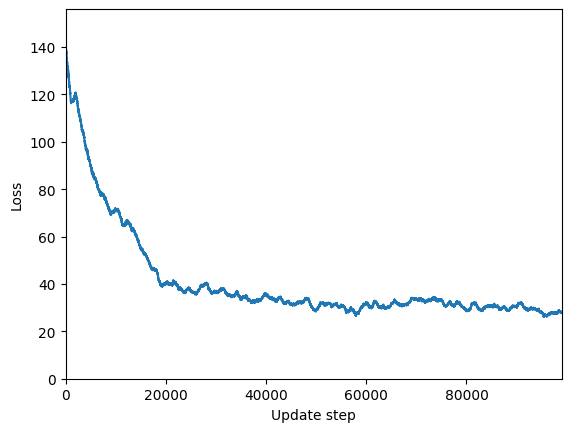

In [63]:
# Train the agent, saving the losses
agent1.epsilon = 0.1
losses = train_loop(agent1, env, interactions_per_update=10, update_steps=100000, sync_delay=1000)
plot_losses(losses)

In [64]:
#print('Performance after training:', evaluate(agent1, randomEnv, 20))

  0%|          | 0/20 [00:00<?, ?it/s]

Game 0

1 | 0 | 0
---------
0 | -1 | 0
---------
0 | 0 | 0

[ 1  0  0  0 -1  0  0  0  0] 0 False False None
1 | 0 | 0
---------
1 | -1 | 0
---------
0 | 0 | -1

[ 1  0  0  1 -1  0  0  0 -1] 0 False False None
1 | 0 | 0
---------
1 | -1 | 0
---------
1 | 0 | -1

[ 1  0  0  1 -1  0  1  0 -1] 50 True False None
Game 1

1 | 0 | 0
---------
0 | 0 | 0
---------
0 | -1 | 0

[ 1  0  0  0  0  0  0 -1  0] 0 False False None
1 | 0 | 0
---------
0 | 0 | -1
---------
1 | -1 | 0

[ 1  0  0  0  0 -1  1 -1  0] 0 False False None
1 | 0 | 0
---------
1 | 0 | -1
---------
1 | -1 | 0

[ 1  0  0  1  0 -1  1 -1  0] 50 True False None
Game 2

1 | 0 | 0
---------
0 | 0 | -1
---------
0 | 0 | 0

[ 1  0  0  0  0 -1  0  0  0] 0 False False None
1 | 0 | 0
---------
0 | -1 | -1
---------
1 | 0 | 0

[ 1  0  0  0 -1 -1  1  0  0] 0 False False None
1 | 0 | 0
---------
1 | -1 | -1
---------
1 | 0 | 0

[ 1  0  0  1 -1 -1  1  0  0] 50 True False None
Game 3

1 | -1 | 0
---------
0 | 0 | 0
---------
0 | 0 | 0

[ 1 -1  0 

In [70]:
# agentCopy1.value_network.load_state_dict(agent1.value_network.state_dict())
# agentCopy1.target_network.load_state_dict(agent1.target_network.state_dict())
# agentCopy2.value_network.load_state_dict(agent1.value_network.state_dict())
# agentCopy2.target_network.load_state_dict(agent1.target_network.state_dict())
# agent1.epsilon = 0.05

